In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [2]:
def load_and_process_data(file_path):
    processed_data = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                data = json.loads(line)
                group_id = data['group']
                current_probe_counts_vector = data['probe_counts']

                if group_id not in processed_data:
                    processed_data[group_id] = {
                        'probe_counts_vectors': [],
                        'vector_length': 0
                    }

                if len(processed_data[group_id]['probe_counts_vectors']) < 100:
                    processed_data[group_id]['probe_counts_vectors'].append(current_probe_counts_vector)

                if processed_data[group_id]['vector_length'] == 0 and current_probe_counts_vector:
                    processed_data[group_id]['vector_length'] = len(current_probe_counts_vector)

        print("Successfully loaded and processed group_traces.jsonl")
        print("\nGroups loaded:", list(processed_data.keys()))

        if processed_data:
            first_group_key = list(processed_data.keys())[0]
            # print(f"\nExample entry for '{first_group_key}':\n", processed_data[first_group_key])
        else:
            print("No data was processed.")
        return processed_data

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
def calculate_minimized_vectors(processed_data):
    minimized_vectors_per_group = {}

    if processed_data is None: # Handle case where data loading failed
        print("Cannot calculate minimized vectors: processed_data is None.")
        return None

    for group_id, group_data in processed_data.items():
        probe_vectors = group_data['probe_counts_vectors']

        if probe_vectors:
            np_probe_vectors = np.array(probe_vectors)
            minimized_vector = np.min(np_probe_vectors, axis=0)
            minimized_vectors_per_group[group_id] = minimized_vector.tolist()

    print("Successfully calculated minimized probe count vectors for the following groups:", list(minimized_vectors_per_group.keys()))

    if minimized_vectors_per_group:
        first_minimized_group_key = list(minimized_vectors_per_group.keys())[0]
        # print(f"\nExample minimized vector for group '{first_minimized_group_key}':\n", minimized_vectors_per_group[first_minimized_group_key])
    else:
        print("No minimized vectors were computed.")
    return minimized_vectors_per_group

In [4]:
import numpy as np

def hierarchical_group_sort(vectors_dict, threshold=1, override=False):
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)

    num_groups, width = M.shape
    col_order = np.arange(width)

    next_start = 0
    # Override values < threshold with 0 for ALL groups if override is True
    if override:
        M = np.where(M < threshold, 0, M)

    for g in range(num_groups):
            
        # 1) Sort the slice M[g, next_start:] in descending order
        slice_vec = M[g, next_start:]
        local_indices = np.argsort(slice_vec)[::-1]  # descending

        # Build full permutation for this stage
        perm = np.concatenate([
            np.arange(next_start),               # untouched prefix
            next_start + local_indices           # reordered suffix
        ])

        # Apply permutation globally
        M = M[:, perm]
        col_order = col_order[perm]

        # 2) Update next_start:
        # Find first index where the value < threshold (after sorting)
        new_region = M[g, next_start:]
        above_threshold_positions = np.where(new_region >= threshold)[0]

        if len(above_threshold_positions) > 0:
            # Set next_start to the first position with value < threshold
            next_start = next_start + above_threshold_positions[-1] + 1
        else:
            # All remaining values are >= threshold, can't sort anymore
            break


        # If next_start reaches the end → done
        if next_start >= width:
            break

    # Build result dict again
    out = {}
    for i, k in enumerate(group_keys):
        out[k] = M[i].tolist()

    return out, col_order.tolist()


In [5]:
def generate_all_heatmaps(groups_vector, filename_prefix="heatmap"):

    if groups_vector is None or not groups_vector:
        print("No averaged vectors available for heatmap generation.")
        return

    heatmaps_dir = "heatmaps"
    os.makedirs(heatmaps_dir, exist_ok=True)

    # Stack all averaged vectors into a single 2D NumPy array
    # Each row will be a group's averaged vector, and columns will be probe indices
    all_averaged_data = np.array(list(groups_vector.values()))

    print(f"Shape of the combined data for heatmap: {all_averaged_data.shape}")

    # Create the heatmap
    plt.figure(figsize=(20, 10)) # Adjust figure size for better readability given the large number of columns
    sns.heatmap(all_averaged_data, cmap='viridis', cbar=True, yticklabels=list(groups_vector.keys()))

    plt.title('Heatmap of Averaged Probe Counts Across All Groups and Probe Indices')
    plt.xlabel('Probe Index (12288 cells)')
    plt.ylabel('Group ID (64 groups)')
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
        # Save the heatmap to file
    output_path = os.path.join(heatmaps_dir, f"{filename_prefix}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved to: {output_path}")
    
    plt.show()

    print("Heatmap generation complete.")

In [6]:
def threshold_vector(v, T):
    v2 = np.copy(v)
    v2[v2 < T] = 0
    return v2

def cosine_similarity(a, b):
    if np.all(a == 0) or np.all(b == 0):
        return 0   # define similarity with zero-vector as 0
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def pairwise_cosine_complement_score(matrix, threshold=1):
    # matrix = list of np.array, one per group
    sims = []
    for i in range(len(matrix)):
        for j in range(i+1, len(matrix)):
            v1 = threshold_vector(matrix[i], threshold)
            v2 = threshold_vector(matrix[j], threshold)
            sims.append(cosine_similarity(v1, v2))
    
    mean_sim = np.mean(sims)
    final_score = 1 - mean_sim
    return final_score

def run_cosine_analysis(vectors_dict, threshold=3):
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)
    score = pairwise_cosine_complement_score(M, threshold=threshold)
    print(f"Cosine analysis score: {score}")

In [7]:
def calculate_coverage_metric(minimized_vectors_per_group, s, w, group_prime=0):

    if minimized_vectors_per_group is None or not minimized_vectors_per_group:
        print("No minimized vectors available for coverage calculation.")
        return 0.0
    
    if group_prime not in minimized_vectors_per_group:
        print(f"Group {group_prime} not found in data.")
        return 0.0
    
    # Get the primary group's vector
    primary_group_vector = np.array(minimized_vectors_per_group[group_prime])
    
    # Calculate sum of misses from index 0 to s-1 (s sets)
    if len(primary_group_vector) < s:
        print(f"Warning: Vector length ({len(primary_group_vector)}) is less than number of sets ({s})")
        sum_of_misses = np.sum(primary_group_vector)
    else:
        sum_of_misses = np.sum(primary_group_vector[:s])
    
    # Calculate score
    denominator = s * w
    if denominator == 0:
        print("Error: s × w cannot be zero")
        return 0.0
    
    score = sum_of_misses / denominator
    
    print(f"Coverage Metric Calculation:")
    print(f"  Sets (s): {s}")
    print(f"  Ways (w): {w}")
    print(f"  Sum of misses (0 to {s-1}): {sum_of_misses}")
    print(f"  Score: {sum_of_misses} / ({s} × {w}) = {score:.6f}")
    
    return score

def run_coverage_analysis(minimized_vectors_per_group, s, w):
    """
    Run coverage analysis for all groups and return results.
    
    Args:
        minimized_vectors_per_group: Dictionary with group_id as key and minimized vector as value
        s: Number of sets in cache (default: 512 for typical L3 cache)
        w: Number of ways in a set (default: 8 for typical L3 cache)
    
    Returns:
        dict: Coverage scores for all groups
    """
    if minimized_vectors_per_group is None:
        return {}
    
    coverage_scores = {}
    
    print(f"\n=== Coverage Analysis (s={s}, w={w}) ===")
    
    for group_id in sorted(minimized_vectors_per_group.keys()):
        score = calculate_coverage_metric(minimized_vectors_per_group, s, w, group_id)
        coverage_scores[group_id] = score
    
    # Summary statistics
    if coverage_scores:
        scores = list(coverage_scores.values())
        print(f"\nCoverage Summary:")
        print(f"  Mean score: {np.mean(scores):.6f}")
        print(f"  Std deviation: {np.std(scores):.6f}")
        print(f"  Min score: {np.min(scores):.6f} (Group {min(coverage_scores, key=coverage_scores.get)})")
        print(f"  Max score: {np.max(scores):.6f} (Group {max(coverage_scores, key=coverage_scores.get)})")
    
    return coverage_scores

In [8]:

# jsonl_files = glob.glob('../data/24MB/*.jsonl')
jsonl_files = glob.glob('../data/64B_stride_L2_prefetcher/24MB_3accesses/*.jsonl')
# jsonl_files = glob.glob('../data/regular_pages/12MB/*.jsonl')
# jsonl_files = glob.glob('../data/spam/*.jsonl')


print("Found JSONL files:", jsonl_files)

Found JSONL files: ['../data/64B_stride_L2_prefetcher/24MB_3accesses/16_group_prime.jsonl', '../data/64B_stride_L2_prefetcher/24MB_3accesses/4_group_prime.jsonl', '../data/64B_stride_L2_prefetcher/24MB_3accesses/32_group_prime.jsonl', '../data/64B_stride_L2_prefetcher/24MB_3accesses/2_group_prime.jsonl', '../data/64B_stride_L2_prefetcher/24MB_3accesses/8_group_prime.jsonl', '../data/64B_stride_L2_prefetcher/24MB_3accesses/1_group_prime.jsonl']


## Process and Plot Heatmaps for Each File

### Subtask:
Iterate through each `.jsonl` file found. For each file, load and process the data, calculate the averaged vectors, and then generate and display a heatmap using the `generate_all_heatmaps` function. This will produce a separate heatmap for each data file.


**Reasoning**:
I will iterate through each `.jsonl` file, process its data, calculate averaged vectors, and then generate a heatmap for each file using the functions defined earlier, as instructed.




Processing file: ../data/64B_stride_L2_prefetcher/24MB_3accesses/16_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cosine analysis score: 0.8178930091685004
Shape of the combined data for heatmap: (16, 16384)
Heatmap saved to: heatmaps/16_group_prime.png


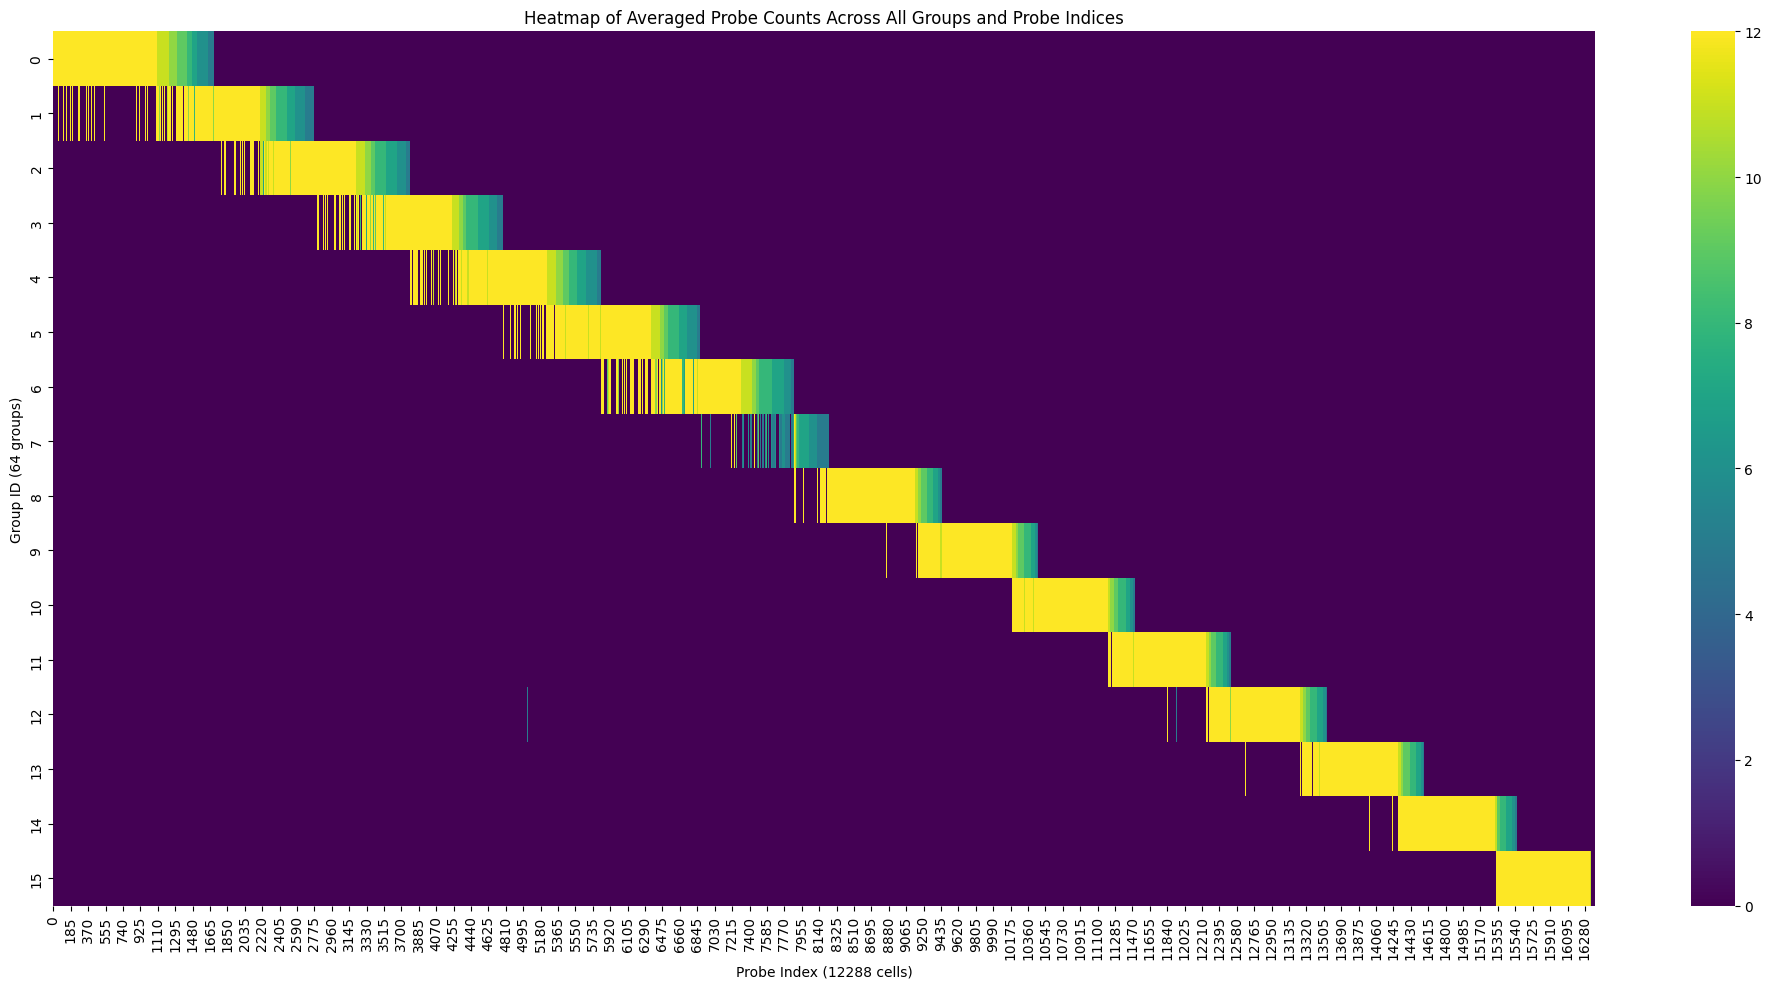

Heatmap generation complete.

Processing file: ../data/64B_stride_L2_prefetcher/24MB_3accesses/4_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3]
Cosine analysis score: 0.6104675247338007
Shape of the combined data for heatmap: (4, 16384)
Heatmap saved to: heatmaps/4_group_prime.png


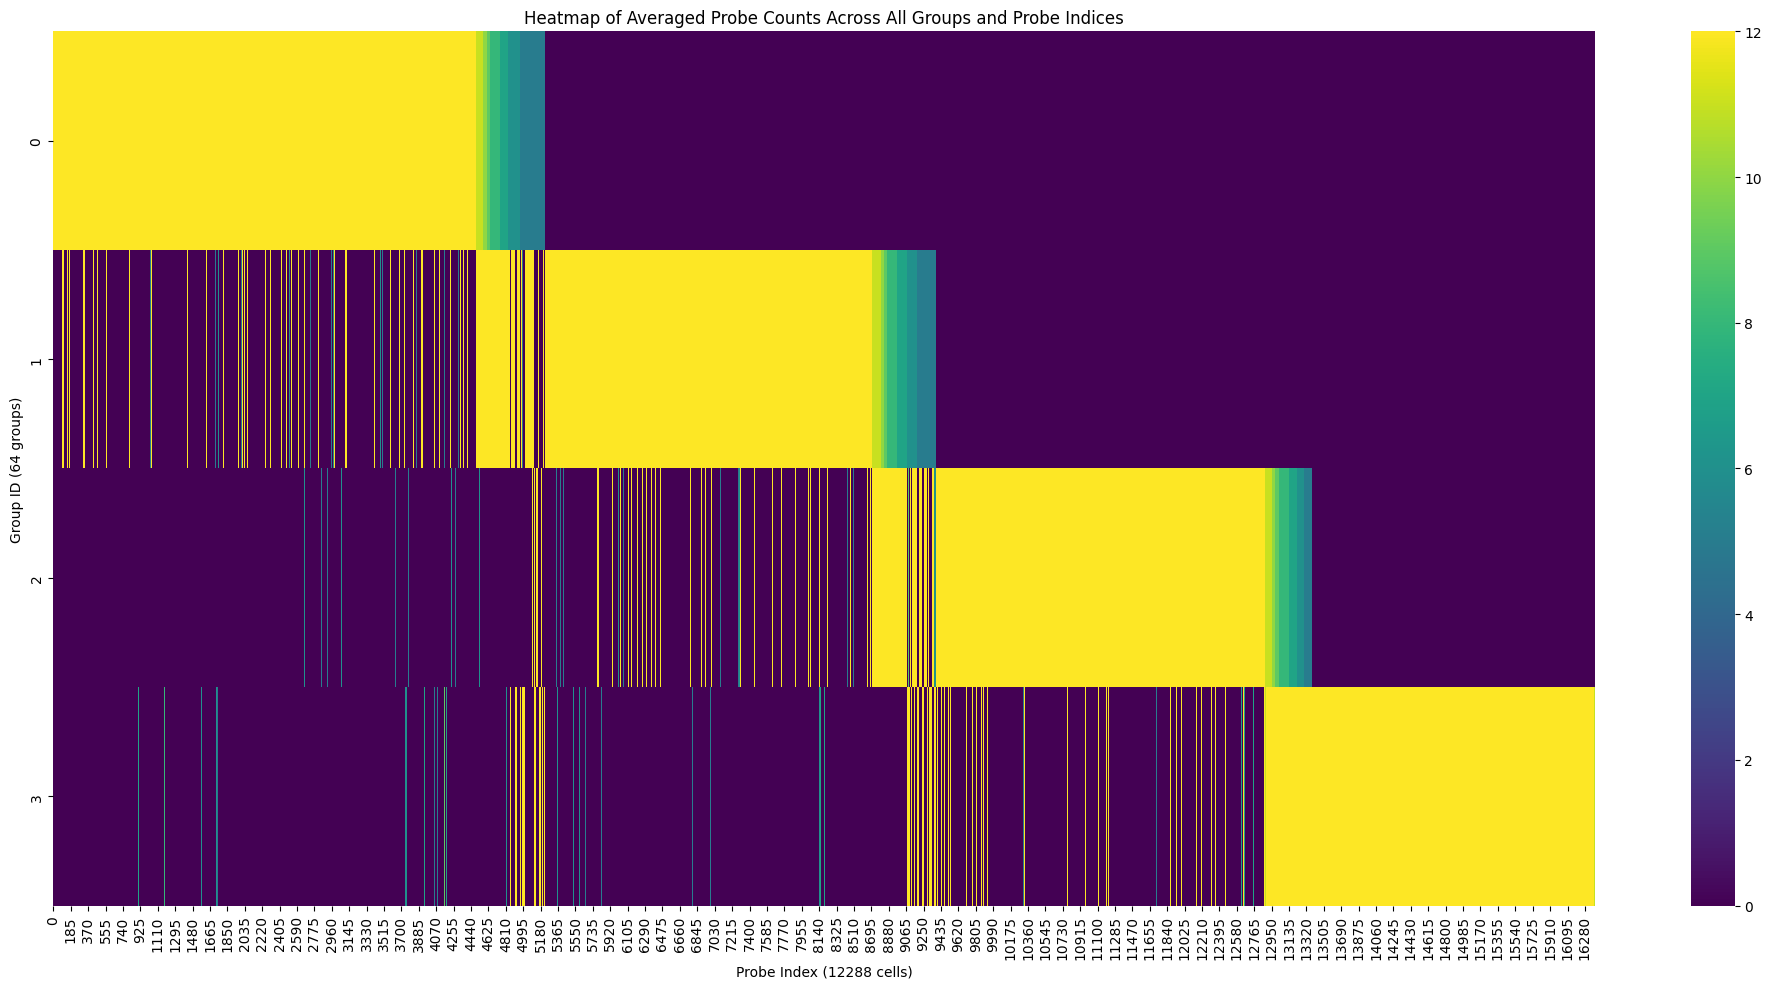

Heatmap generation complete.

Processing file: ../data/64B_stride_L2_prefetcher/24MB_3accesses/32_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Cosine analysis score: 0.7804858541883283
Shape of the combined data for heatmap: (32, 16384)
Heatmap saved to: heatmaps/32_group_prime.png


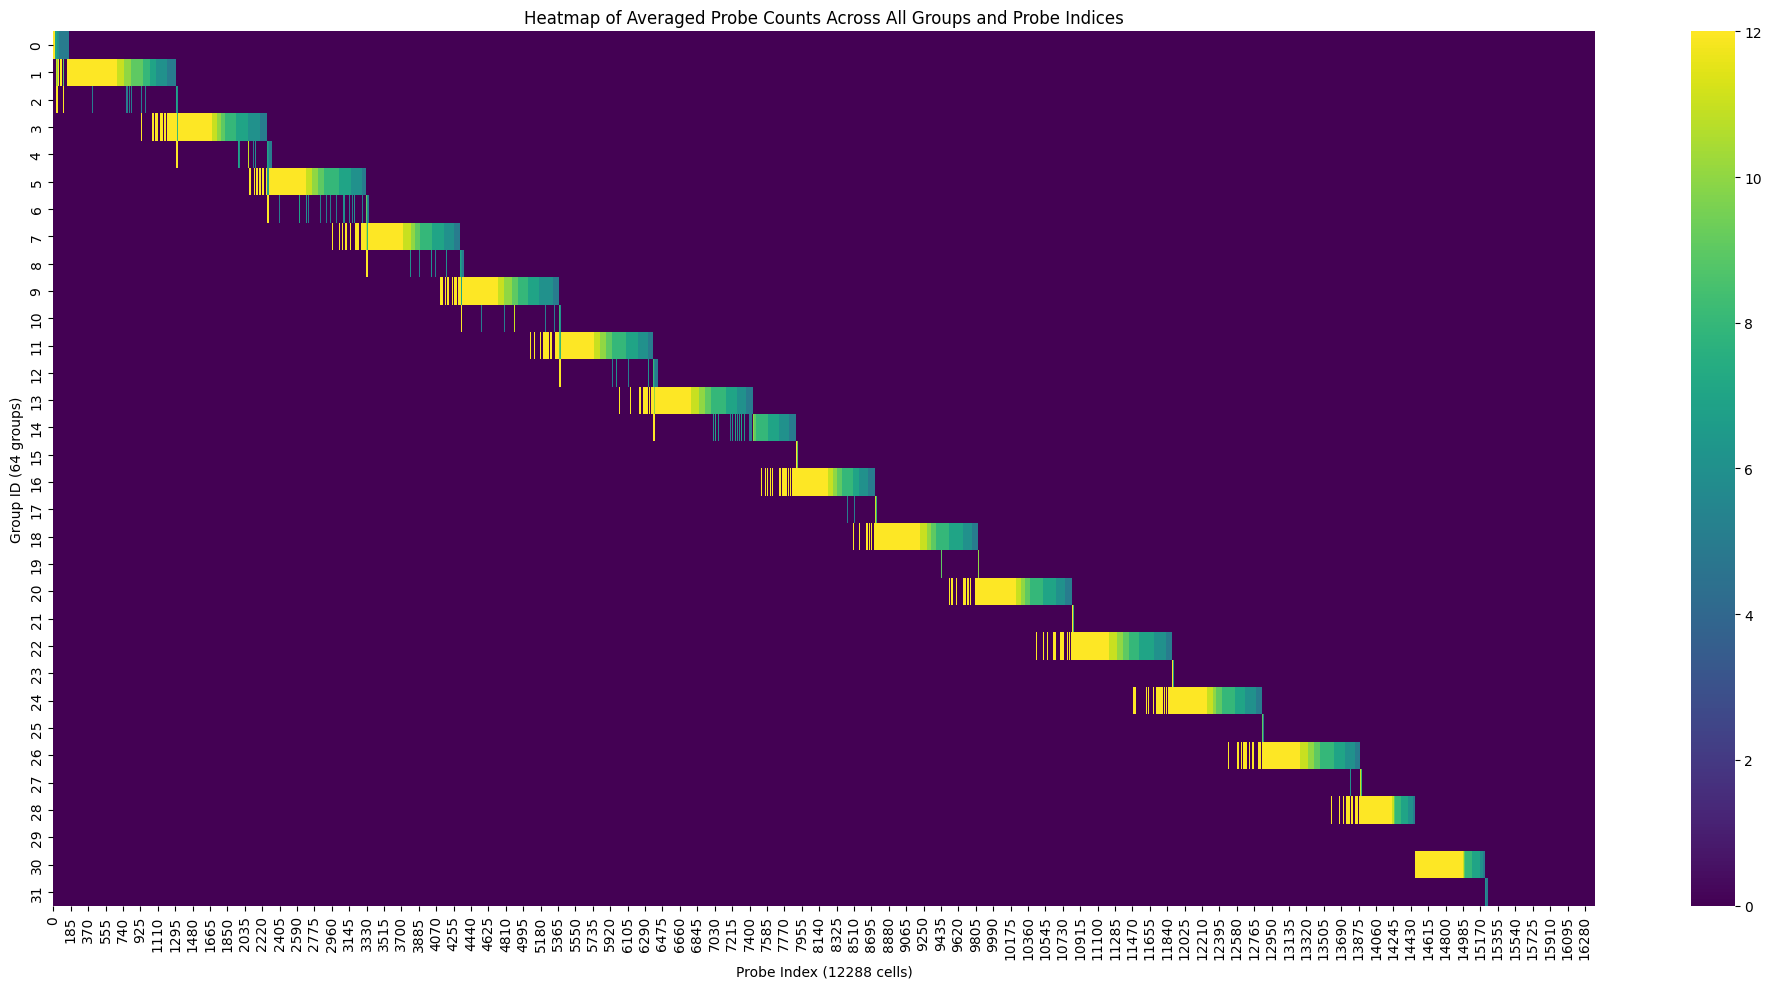

Heatmap generation complete.

Processing file: ../data/64B_stride_L2_prefetcher/24MB_3accesses/2_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1]
Successfully calculated minimized probe count vectors for the following groups: [0, 1]
Cosine analysis score: 0.4055853931739235
Shape of the combined data for heatmap: (2, 16384)
Heatmap saved to: heatmaps/2_group_prime.png


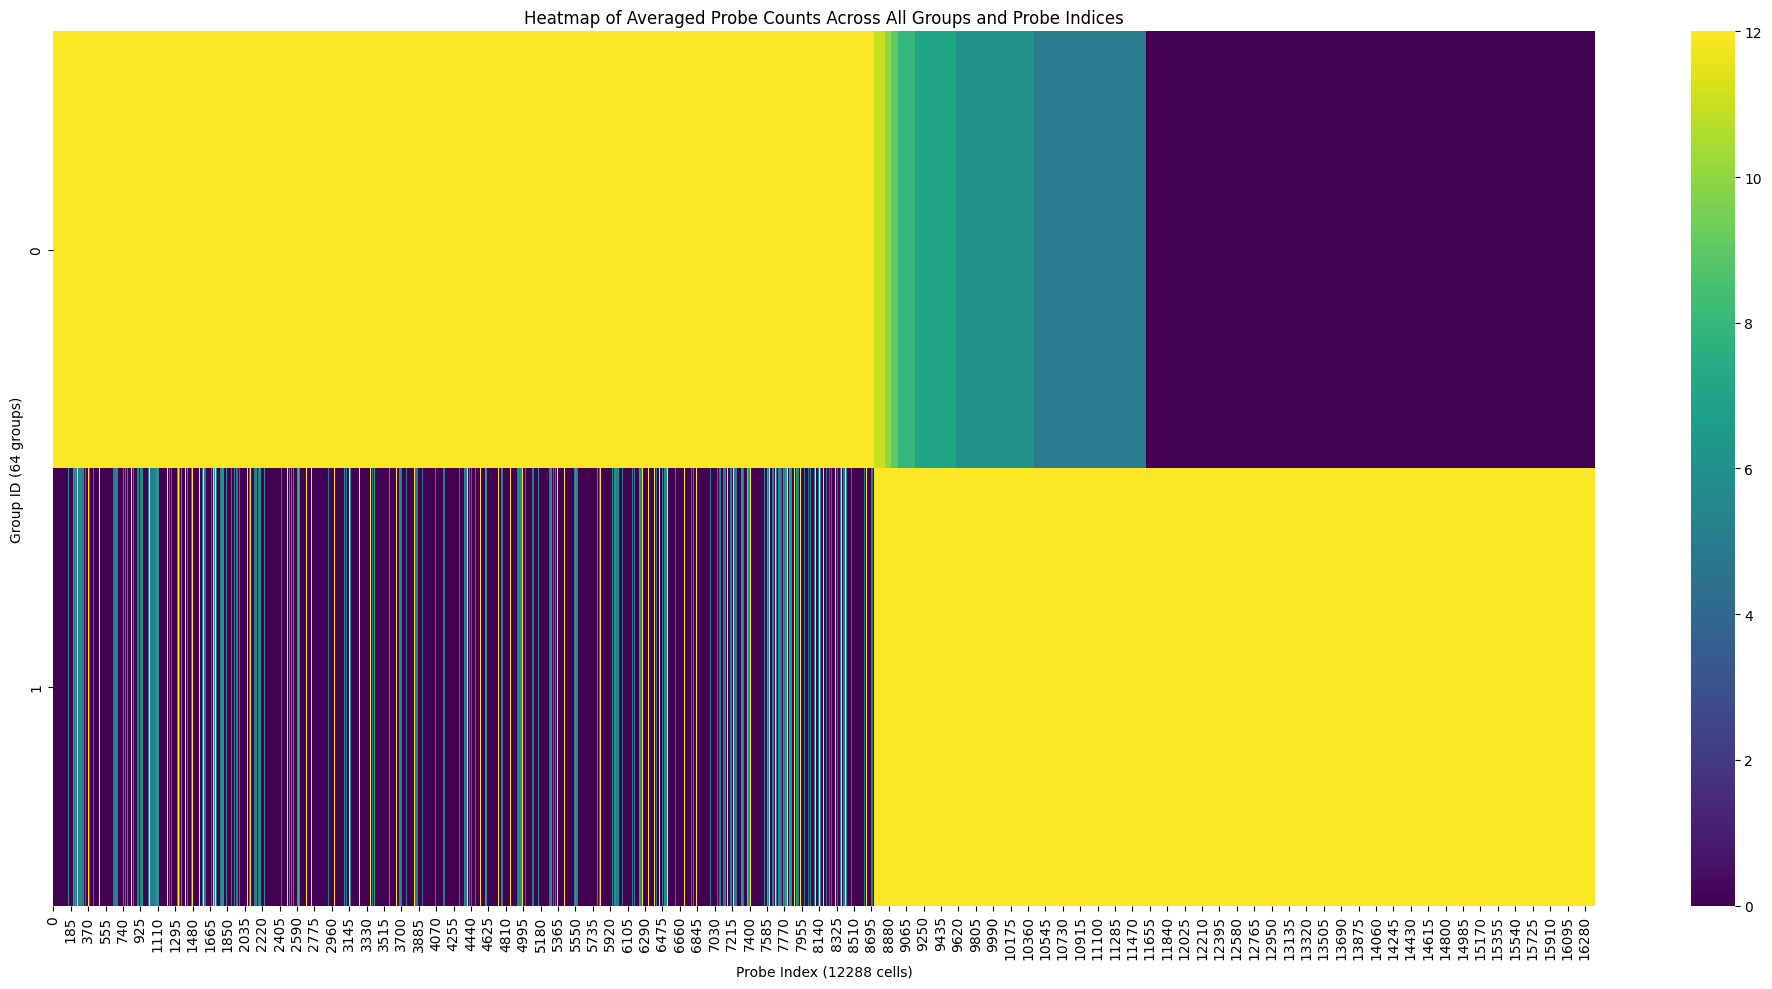

Heatmap generation complete.

Processing file: ../data/64B_stride_L2_prefetcher/24MB_3accesses/8_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0, 1, 2, 3, 4, 5, 6, 7]
Successfully calculated minimized probe count vectors for the following groups: [0, 1, 2, 3, 4, 5, 6, 7]
Cosine analysis score: 0.7360384327768619
Shape of the combined data for heatmap: (8, 16384)
Heatmap saved to: heatmaps/8_group_prime.png


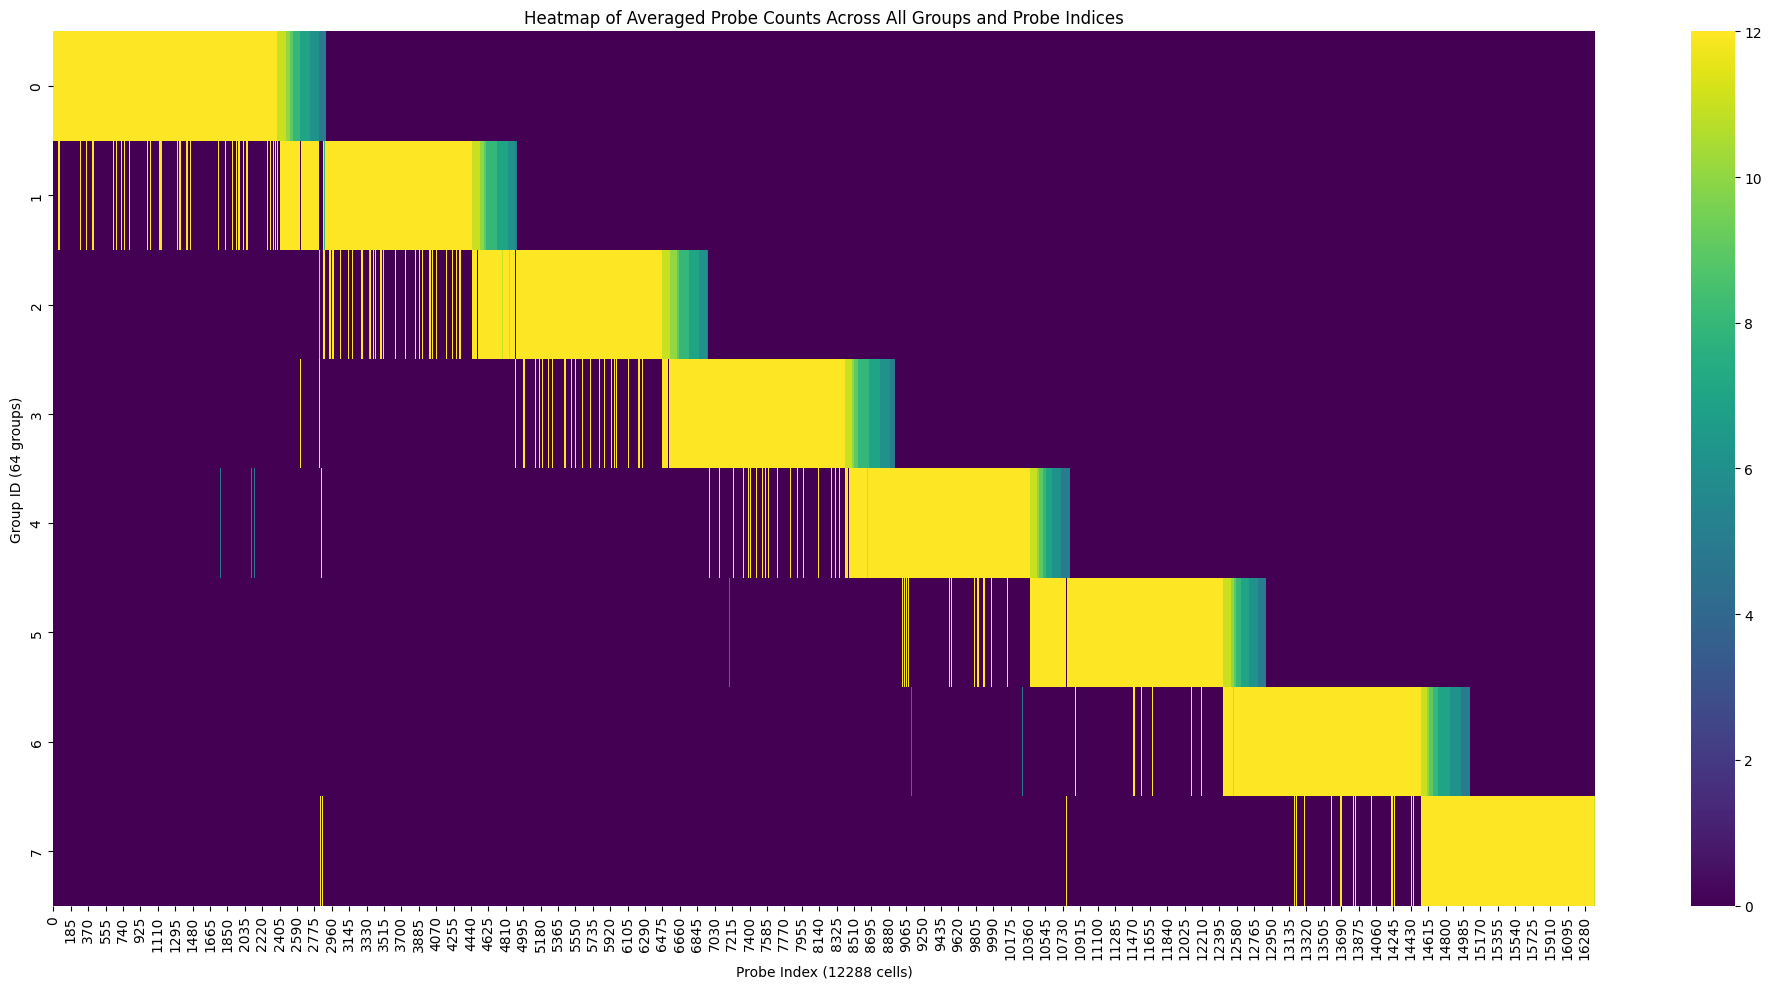

Heatmap generation complete.

Processing file: ../data/64B_stride_L2_prefetcher/24MB_3accesses/1_group_prime.jsonl
Successfully loaded and processed group_traces.jsonl

Groups loaded: [0]
Successfully calculated minimized probe count vectors for the following groups: [0]

=== Coverage Analysis (s=16384, w=12) ===
Coverage Metric Calculation:
  Sets (s): 16384
  Ways (w): 12
  Sum of misses (0 to 16383): 196608
  Score: 196608 / (16384 × 12) = 1.000000

Coverage Summary:
  Mean score: 1.000000
  Std deviation: 0.000000
  Min score: 1.000000 (Group 0)
  Max score: 1.000000 (Group 0)
Shape of the combined data for heatmap: (1, 16384)
Heatmap saved to: heatmaps/1_group_prime.png


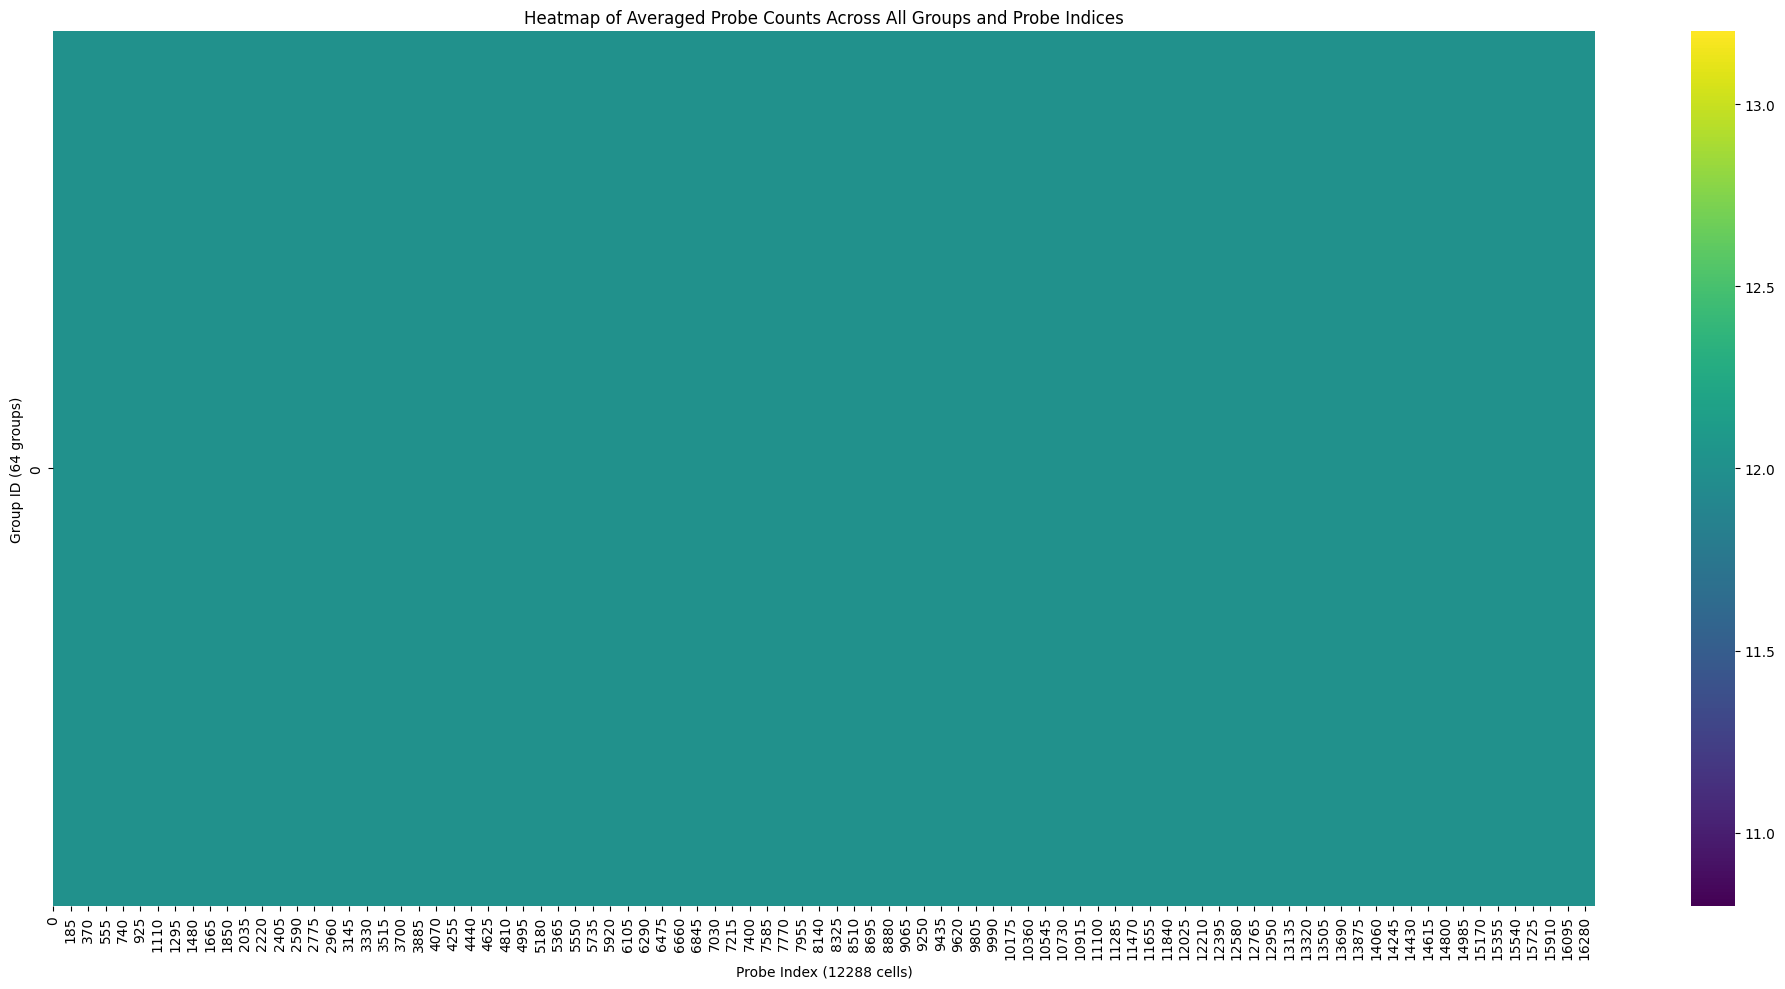

Heatmap generation complete.


In [9]:
for file_path in jsonl_files:
    print(f"\nProcessing file: {file_path}")
    processed_data = load_and_process_data(file_path)
    if processed_data:
        minimized_vectors_per_group = calculate_minimized_vectors(processed_data)
        filename_base = os.path.splitext(os.path.basename(file_path))[0]
        
        # Check if filename starts with "1_"
        if filename_base.startswith('1_'):
            # Use override=False for files starting with "1"
            reordered_vectors, col_order = hierarchical_group_sort(minimized_vectors_per_group, threshold=3, override=False)         
            # Check if the specific file is "1_group_prime.jsonl"
            if filename_base == '1_group_prime':
                coverage_scores = run_coverage_analysis(minimized_vectors_per_group, s=16384, w=12)
        else:
            # Use override=True for other files
            run_cosine_analysis(minimized_vectors_per_group, threshold=1)
            reordered_vectors, col_order = hierarchical_group_sort(minimized_vectors_per_group, threshold=5, override=True)

        
        
        if minimized_vectors_per_group:
            # generate_all_heatmaps(minimized_vectors_per_group, filename_prefix=filename_base)
            generate_all_heatmaps(reordered_vectors, filename_prefix=filename_base)


        else:
            print(f"Could not calculate minimized vectors for {file_path}.")
    else:
        print(f"Could not load and process data from {file_path}.")

In [10]:
def create_group_missed_sets_matrix(jsonl_files):
    """
    Create a 3D matrix structure where each group has aggregated missed_sets data.
    
    Args:
        jsonl_files: List of JSONL file paths to process
    
    Returns:
        dict: Dictionary where keys are group IDs and values are 2D numpy arrays 
              with shape [n_sets, 2] where columns are [set_index, num_misses]
    """
    from collections import defaultdict
    
    # Dictionary to store aggregated data per group
    # group_id -> {set_index -> total_num_misses}
    group_data = defaultdict(lambda: defaultdict(int))
    
    total_lines = 0
    
    # Process all JSONL files
    for filepath in jsonl_files:
        print(f"Processing: {filepath}")
        with open(filepath, 'r') as f:
            for line in f:
                total_lines += 1
                data = json.loads(line)
                group_id = data.get('group')
                missed_sets = data.get('missed_sets', [])
                
                # Aggregate num_misses for each set_index within this group
                for set_index, num_misses in missed_sets:
                    group_data[group_id][set_index] += num_misses
    
    print(f"\nTotal lines processed: {total_lines}")
    print(f"Total groups found: {len(group_data)}")
    
    # Convert to 3D matrix structure (dict of 2D arrays)
    matrix_3d = {}
    total_misses_per_group = []
    all_misses_per_set = []  # Collect all num_misses values across all sets
    distinct_sets_per_group = []  # Track number of distinct sets per group
    
    for group_id in sorted(group_data.keys()):
        set_data = group_data[group_id]
        # Convert to 2D array: [[set_index, num_misses], ...]
        matrix_2d = np.array([[set_idx, misses] 
                              for set_idx, misses in sorted(set_data.items())])
        matrix_3d[group_id] = matrix_2d
        
        group_total = matrix_2d[:, 1].sum()
        total_misses_per_group.append(group_total)
        
        # Count distinct sets for this group
        distinct_sets_per_group.append(len(set_data))
        
        # Collect all num_misses values for this group
        all_misses_per_set.extend(matrix_2d[:, 1].tolist())
    
    # Calculate and display statistics across all groups
    if total_misses_per_group:
        total_misses_array = np.array(total_misses_per_group)
        print(f"\n{'='*50}")
        print(f"Statistics Across All Groups:")
        print(f"{'='*50}")
        print(f"  Mean total misses per group:   {np.mean(total_misses_array):.2f}")
        print(f"  Std deviation:                 {np.std(total_misses_array):.2f}")
        print(f"  Min total misses:              {np.min(total_misses_array):.0f}")
        print(f"  Max total misses:              {np.max(total_misses_array):.0f}")
        print(f"  Median total misses:           {np.median(total_misses_array):.2f}")
        print(f"  Total misses (all groups):     {np.sum(total_misses_array):.0f}")
        print(f"{'='*50}\n")
    
    # Calculate and display statistics for num_misses per set
    if all_misses_per_set:
        misses_per_set_array = np.array(all_misses_per_set)
        print(f"{'='*50}")
        print(f"Statistics for Num Misses Per Set:")
        print(f"{'='*50}")
        print(f"  Total unique sets:             {len(all_misses_per_set)}")
        print(f"  Mean misses per set:           {np.mean(misses_per_set_array):.2f}")
        print(f"  Std deviation:                 {np.std(misses_per_set_array):.2f}")
        print(f"  Min misses per set:            {np.min(misses_per_set_array):.0f}")
        print(f"  Max misses per set:            {np.max(misses_per_set_array):.0f}")
        print(f"  Median misses per set:         {np.median(misses_per_set_array):.2f}")
        print(f"{'='*50}\n")
    
    # Calculate and display statistics for distinct sets per group
    if distinct_sets_per_group:
        distinct_sets_array = np.array(distinct_sets_per_group)
        print(f"{'='*50}")
        print(f"Statistics for Distinct Sets Per Group:")
        print(f"{'='*50}")
        print(f"  Mean distinct sets per group:  {np.mean(distinct_sets_array):.2f}")
        print(f"  Std deviation:                 {np.std(distinct_sets_array):.2f}")
        print(f"  Min distinct sets:             {np.min(distinct_sets_array):.0f}")
        print(f"  Max distinct sets:             {np.max(distinct_sets_array):.0f}")
        print(f"  Median distinct sets:          {np.median(distinct_sets_array):.2f}")
        print(f"  Total distinct sets (all):     {sum(distinct_sets_array):.0f}")
        print(f"{'='*50}\n")
    
    return matrix_3d
  
    

def plot_group_missed_sets_heatmap(matrix_3d, max_sets=None):
    """
    Plot a heatmap of missed sets across all groups.
    
    Args:
        matrix_3d: Dictionary from create_group_missed_sets_matrix()
        max_sets: Maximum set index to display (None for auto-detect)
    """
    # Determine the maximum set_index across all groups
    if max_sets is None:
        max_sets = 0
        for group_data in matrix_3d.values():
            if len(group_data) > 0:
                max_sets = max(max_sets, int(group_data[:, 0].max()))
        max_sets += 1  # Convert to count
    
    print(f"Creating heatmap for {len(matrix_3d)} groups and {max_sets} sets")
    
    # Create a 2D array: rows = groups, cols = set indices
    groups = sorted(matrix_3d.keys())
    heatmap_data = np.zeros((len(groups), max_sets))
    
    for i, group_id in enumerate(groups):
        group_matrix = matrix_3d[group_id]
        for set_idx, num_misses in group_matrix:
            if set_idx < max_sets:
                heatmap_data[i, int(set_idx)] = num_misses
    
    # Plot
    plt.figure(figsize=(20, 10))
    sns.heatmap(heatmap_data, cmap='hot', cbar=True, 
                yticklabels=groups,
                xticklabels=False)
    
    plt.title(f'Heatmap of Missed Sets Across Groups (Total Sets: {max_sets})')
    plt.xlabel('Set Index')
    plt.ylabel('Group ID')
    plt.tight_layout()
    
    # Save
    output_path = 'heatmaps/missed_sets_by_group_heatmap.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved to: {output_path}")
    
    plt.show()
    
    return heatmap_data

Number of groups: 64
Vector length: 16384
Total misses in group 63: 79832
Cosine complement score (threshold=1): 0.016642
Groups Per-set: #groups where set appeared (miss>0)
  min=1, max=64, mean=7.244080, median=7.000000, std=3.851784
Per-group: total misses (sum over sets)
  min=78666, max=89067, mean=82893.500000, median=83168.000000, std=2374.416369
Misses Per-set: total misses (sum over groups)
  min=6, max=189234, mean=323.802734, median=30.000000, std=6703.246427
All matrix values:
  min=0, max=2998, mean=5.059418, median=0.000000, std=105.620540


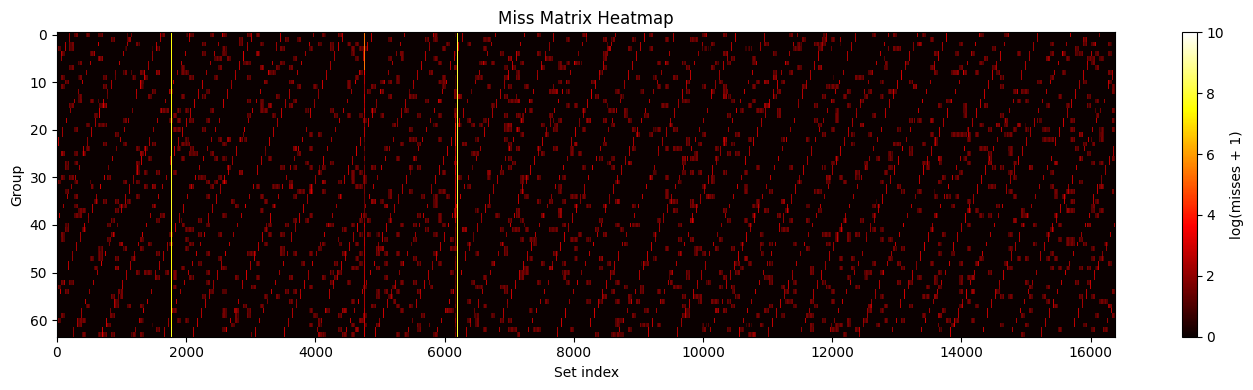

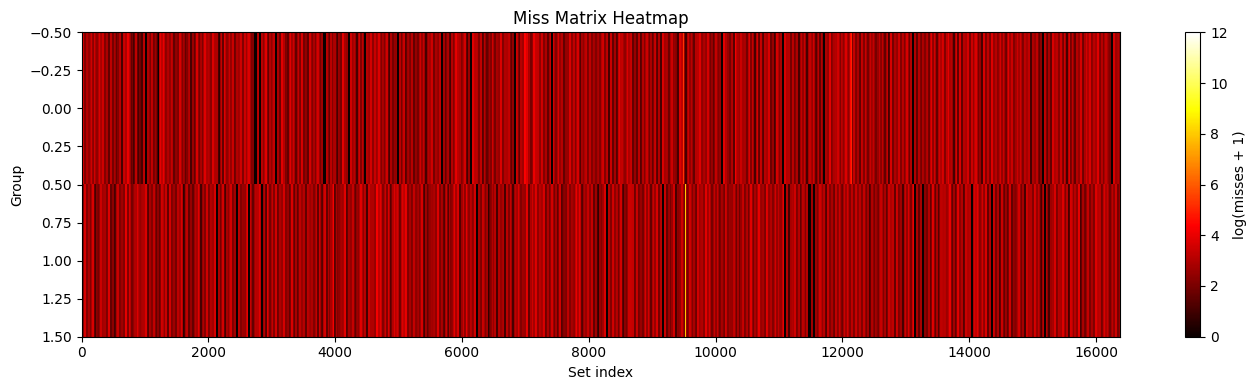

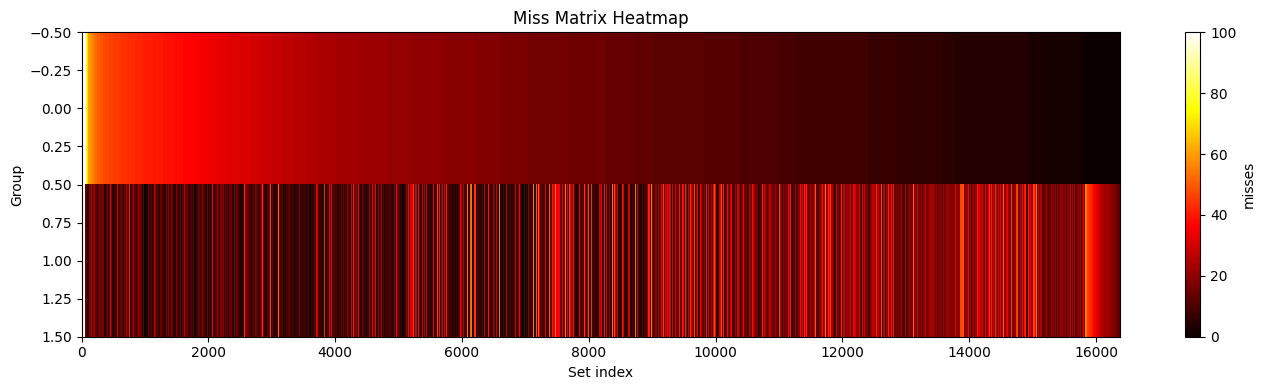

In [11]:
import json
import numpy as np

def load_miss_dict(jsonl_path, num_groups=64, num_sets=16384):
    """
    Returns miss_dict[group] = vector where vector[set_index] = total num_misses
    Each vector has length num_sets
    """
    miss_dict = {}
    
    # Initialize all groups with zero vectors
    for g in range(num_groups):
        miss_dict[g] = [0] * num_sets
    
    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            g = entry["group"]
            
            for set_idx, misses in entry["missed_sets"]:
                miss_dict[g][set_idx] += misses
    
    return miss_dict


def print_miss_dict_stats(miss_dict: dict) -> None:
    """
    miss_dict: dict where miss_dict[group] = vector of misses per set
    Prints same statistics as print_miss_matrix_stats
    """
    # Convert to matrix for calculations
    group_keys = sorted(miss_dict.keys())
    miss_matrix = np.array([miss_dict[k] for k in group_keys], dtype=np.uint32)
    
    if miss_matrix.ndim != 2:
        raise ValueError(f"Expected 2D matrix (groups x sets). Got shape={miss_matrix.shape}")

    # (1) For each set: in how many groups it appeared (nonzero in that group)
    groups_per_set = (miss_matrix > 0).sum(axis=0).astype(np.int32)

    gps_min = int(groups_per_set.min())
    gps_max = int(groups_per_set.max())
    gps_mean = float(groups_per_set.mean())
    gps_median = float(np.median(groups_per_set))
    gps_std = float(groups_per_set.std(ddof=0))

    print("Groups Per-set: #groups where set appeared (miss>0)")
    print(f"  min={gps_min}, max={gps_max}, mean={gps_mean:.6f}, median={gps_median:.6f}, std={gps_std:.6f}")

    # (2) Sum misses in each group
    misses_per_group = miss_matrix.sum(axis=1).astype(np.uint64)

    g_min = int(misses_per_group.min())
    g_max = int(misses_per_group.max())
    g_mean = float(misses_per_group.mean())
    g_median = float(np.median(misses_per_group))
    g_std = float(misses_per_group.std(ddof=0))

    print("Per-group: total misses (sum over sets)")
    print(f"  min={g_min}, max={g_max}, mean={g_mean:.6f}, median={g_median:.6f}, std={g_std:.6f}")

    # (3) Sum misses per set 
    misses_per_set = miss_matrix.sum(axis=0).astype(np.uint64)

    s_min = int(misses_per_set.min())
    s_max = int(misses_per_set.max())
    s_mean = float(misses_per_set.mean())
    s_median = float(np.median(misses_per_set))
    s_std = float(misses_per_set.std(ddof=0))

    print("Misses Per-set: total misses (sum over groups)")
    print(f"  min={s_min}, max={s_max}, mean={s_mean:.6f}, median={s_median:.6f}, std={s_std:.6f}")

    # (4) All matrix values
    all_values = miss_matrix.flatten()
    
    val_min = int(all_values.min())
    val_max = int(all_values.max())
    val_mean = float(all_values.mean())
    val_median = float(np.median(all_values))
    val_std = float(all_values.std(ddof=0))

    print("All matrix values:")
    print(f"  min={val_min}, max={val_max}, mean={val_mean:.6f}, median={val_median:.6f}, std={val_std:.6f}")


def plot_miss_heatmap_dict(miss_dict: dict,
                           log_scale: bool = True,
                           vmax: int | None = None):
    """
    Plots a heatmap from miss_dict (groups x sets).

    Parameters:
    - miss_dict: dict where miss_dict[group] = vector of misses
    - log_scale: apply log1p to improve visibility (recommended)
    - vmax: optional upper bound for color scale
    """
    # Convert to matrix
    group_keys = sorted(miss_dict.keys())
    miss_matrix = np.array([miss_dict[k] for k in group_keys], dtype=float)

    data = miss_matrix

    if log_scale:
        data = np.log1p(data)   # log(1 + x) to keep zeros

    plt.figure(figsize=(14, 4))
    plt.imshow(
        data,
        aspect="auto",
        interpolation="nearest",
        cmap="hot",
        vmax=vmax
    )

    plt.colorbar(label="log(misses + 1)" if log_scale else "misses")
    plt.xlabel("Set index")
    plt.ylabel("Group")
    plt.title("Miss Matrix Heatmap")

    plt.tight_layout()
    plt.show()


def reduce_groups_dict(vectors_dict: dict, new_num_groups: int) -> dict:
    """
    Merge the 64 groups into `new_num_groups` by summing consecutive group blocks.

    Logic:
      numGroupsToMerge = 64 / new_num_groups
      new_group[i] = sum of old groups [i*numGroupsToMerge : (i+1)*numGroupsToMerge]

    Example:
      new_num_groups=2 -> groups [0..31] -> new group 0, groups [32..63] -> new group 1

    Args:
      vectors_dict: dict with group_id as key and vector as value (64 groups expected)
      new_num_groups: int, must divide 64

    Returns:
      reduced_dict: dict with new_num_groups entries, keys are new group indices
    """
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    
    if len(group_keys) != 64:
        raise ValueError(f"Expected 64 groups in vectors_dict. Got {len(group_keys)}")
    
    if new_num_groups <= 0 or (64 % new_num_groups) != 0:
        raise ValueError("new_num_groups must be a positive divisor of 64 (e.g., 1,2,4,8,16,32,64).")
    
    # Convert to matrix
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)
    
    num_groups_to_merge = 64 // new_num_groups
    # reshape to (new_num_groups, num_groups_to_merge, num_sets) then sum over merged axis
    reduced = M.reshape(new_num_groups, num_groups_to_merge, M.shape[1]).sum(axis=1)
    
    # Convert back to dict
    reduced_dict = {}
    for i in range(new_num_groups):
        reduced_dict[i] = reduced[i].tolist()
    
    return reduced_dict


def hierarchical_row_sort_dict(vectors_dict: dict, threshold=1, override=False, descending=True):
    """
    Hierarchically sorts columns of vectors in dict format.
    Same logic as hierarchical_row_sort_matrix but works with dict.
    
    Returns:
      sorted_dict: dict with sorted vectors
      col_order: list of original column indices after sorting
    """
    # Convert dict to sorted list of groups
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=float)

    num_groups, width = M.shape
    col_order = np.arange(width)

    if override:
        M = np.where(M < threshold, 0.0, M)

    next_start = 0
    for g in range(num_groups):
        if next_start >= width:
            break

        # Sort suffix of the CURRENT row
        suffix = M[g, next_start:]
        if suffix.size == 0:
            break

        local_idx = np.argsort(suffix)
        if descending:
            local_idx = local_idx[::-1]

        perm = np.concatenate([np.arange(next_start), next_start + local_idx])

        # Apply permutation globally to all rows and to col_order
        M = M[:, perm]
        col_order = col_order[perm]

        # Advance next_start to end of the >=threshold region in this row
        new_region = M[g, next_start:]
        above = np.where(new_region >= threshold)[0]
        if above.size > 0:
            next_start = next_start + above[-1] + 1
        else:
            # Nothing above threshold in remaining region; stop (no more stable region)
            break

    # Convert back to dict
    sorted_dict = {}
    for i, k in enumerate(group_keys):
        sorted_dict[k] = M[i].tolist()

    return sorted_dict, col_order.tolist()


def dump_sorted_dict_entries(
    vectors_dict: dict,
    output_path: str,
    descending: bool = True,
    skip_zeros: bool = True,
    sort_by: str = "value"  # "value" or "group_set"
) -> None:
    """
    Writes all (group, set, value) entries to a file, sorted by specified criteria.

    Output format (one per line):
      group <g>; set <s> --> <value>

    Args:
      vectors_dict: dict with group_id as key and vector as value
      output_path: path to output text file
      descending: sort high -> low if True, else low -> high
      skip_zeros: if True, entries with value == 0 are omitted
      sort_by: "value" to sort by miss count, "group_set" to sort by (group, set_index)
    """
    entries = []
    for g in sorted(vectors_dict.keys()):
        vector = vectors_dict[g]
        for s, v in enumerate(vector):
            if skip_zeros and v == 0:
                continue
            entries.append((v, g, s))

    # sort based on sort_by parameter
    if sort_by == "group_set":
        entries.sort(key=lambda x: (x[1], x[2]), reverse=descending)
    else:  # default: sort by value
        entries.sort(key=lambda x: x[0], reverse=descending)

    with open(output_path, "w") as f:
        for v, g, s in entries:
            f.write(f"group {g}; set {s} --> {int(v)}\n")


def dump_sorted_misses_per_set_dict(
    vectors_dict: dict,
    output_path: str,
    descending: bool = True,
    skip_zeros: bool = True
) -> None:
    """
    Sums misses per set across all groups and writes them sorted to a file.

    Output format (one per line):
      set <set_index> --> <total_misses>

    Args:
      vectors_dict: dict with group_id as key and vector as value
      output_path: path to output text file
      descending: sort high -> low if True, else low -> high
      skip_zeros: if True, omit sets with total_misses == 0
    """
    # Convert to matrix
    group_keys = sorted(vectors_dict.keys())
    M = np.array([vectors_dict[k] for k in group_keys], dtype=np.uint64)

    misses_per_set = M.sum(axis=0).astype(np.uint64)

    entries = []
    for s, total in enumerate(misses_per_set):
        if skip_zeros and total == 0:
            continue
        entries.append((total, s))

    entries.sort(key=lambda x: x[0], reverse=descending)

    with open(output_path, "w") as f:
        for total, s in entries:
            f.write(f"set {s} --> {int(total)}\n")


# Load data as dict
miss_dict = load_miss_dict("/home/ubu/Desktop/Michael/lazyMapping/data/prime_by_group_line/64_group_prime.jsonl")
print(f"Number of groups: {len(miss_dict)}")
print(f"Vector length: {len(miss_dict[0])}")
print(f"Total misses in group 63: {sum(miss_dict[63])}")
cosine_scores = pairwise_cosine_complement_score(miss_dict,threshold=1)
print (f"Cosine complement score (threshold=1): {cosine_scores:.6f}")


# Print statistics
print_miss_dict_stats(miss_dict)

# Plot heatmap
plot_miss_heatmap_dict(miss_dict, log_scale=True, vmax=10)

# Reduce groups
M_reduced_dict = reduce_groups_dict(miss_dict, new_num_groups=2)

# Sort reduced dict
M_sorted_dict, col_order = hierarchical_row_sort_dict(M_reduced_dict, threshold=1, override=True)

# Plot reduced
plot_miss_heatmap_dict(M_reduced_dict, log_scale=True, vmax=12)

# Plot sorted
plot_miss_heatmap_dict(M_sorted_dict, log_scale=False, vmax=100)

# Dump sorted entries
dump_sorted_dict_entries(
    miss_dict,
    "sorted_miss_entries.txt",
    descending=True,
    skip_zeros=True
)

dump_sorted_misses_per_set_dict(
    miss_dict,
    "misses_per_set.txt",
    descending=True,
    skip_zeros=False
)

dump_sorted_dict_entries(
    miss_dict, 
    "sorted_by_group_set.txt",
    descending=False,
    skip_zeros=True,
    sort_by="group_set"
)